In [19]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
# !pip install pennylane
import time
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1700503860.1867297
Mon Nov 20 18:11:00 2023


Quantum advantage in learning from experiments
==============================================

::: {.meta}
:property=\"og:description\": Learn how quantum memory can boost quantum
machine learning algorithms :property=\"og:image\":
<https://pennylane.ai/qml/_images/learning_from_exp_thumbnail.png>
:::

*Author: Joseph Bowles --- Posted: 18 April 2022. Last updated: 30 June
2022.*

This demo is based on the article [Quantum advantage in learning from
experiments](https://arxiv.org/abs/2112.00778) [\[1\]](#ref1) by
Hsin-Yuan Huang and co-authors. The article investigates the following
question:

*How useful is access to quantum memory for quantum machine learning?*

They show that access to quantum memory can make a big difference, and
prove that there exist learning problems for which algorithms with
quantum memory require *exponentially less resources* than those
without. We look at one learning task studied in [\[1\]](#ref1) for
which this is the case.

The learning task
-----------------

The learning task we focus on involves deciding if a unitary is
time-reversal symmetric (we'll call them T-symmetric) or not.
Mathematically, time-reversal symmetry in quantum mechanics involves
reversing the sense of $i$ so that $i \rightarrow -i$. Hence, a unitary
$U$ is T-symmetric if

$$U^*=U.$$

Now for the learning task. Let's say we have a bunch of quantum circuits
$U_1, \cdots, U_n$, some of which are T-symmetric and some not, but we
are not told which ones are which.


![](../demonstrations/learning_from_experiments/fig1b.png){.align-center
width="50.0%"}


The task is to design an algorithm to determine which of the $U$'s are
T-symmetric and which are not, given query access to the unitaries. Note
that we do not have any labels here, so this is an unsupervised learning
task. To make things concrete, let's consider unitaries acting on 8
qubits. We will also limit the number of times we can use each unitary:


In [20]:
qubits = 8  # the number of qubits on which the unitaries act
n_shots = 100  # the number of times we can use each unitary

Experiments with and without a quantum memory
=============================================


To tackle this task we consider experiments with and without quantum
memory. We also assume that we have access to a single physical
realization of each unitary; in other words, we do not have multiple
copies of the devices that implement $U_i$.

An experiment without quantum memory can therefore only make use of a
single query to $U_i$ in each circuit, since querying $U_i$ again would
require storing the state of the first query in memory and re-using the
unitary. In the paper these experiments are called **conventional
experiments**.

Experiments with quantum memory do not have the limitations of
conventional experiments. This means that multiple queries can be made
to $U_i$ in a single circuit, which can be realized in practice by using
a quantum memory. These experiments are called **quantum-enhanced
experiments**.

Note that we are not comparing classical and quantum algorithms here,
but rather two classes of quantum algorithms.


![](../demonstrations/learning_from_experiments/experiments.png){.align-center
width="60.0%"}


The conventional way
====================


First, we will try to solve the task with a conventional experiment. Our
strategy will be as follows:

-   For each $U_i$, we prepare `n_shots` copies of the state
    $U_i\vert0\rangle$ and measure each state to generate classical
    measurement data.
-   Use an unsupervised classical machine learning algorithm (kernel
    PCA), to try and separate the data into two clusters corresponding
    to T-symmetric unitaries vs. the rest.

If we succeed in clustering the data then we have successfully managed
to discriminate the two classes!


![](../demonstrations/learning_from_experiments/fig2b.png){.align-center
width="70.0%"}


To generate the measurement data, we will measure the states
$U_i\vert0\rangle$ in the $y$ basis. The local expectation values take
the form

$$E_i  = \langle 0\vert U^{\dagger}\sigma_y^{(i)} U \vert 0 \rangle.$$

where $\sigma_y^{(i)}$ acts on the $i^{\text{th}}$ qubit.

Using the fact that $\sigma_y^*=-\sigma_y$ and the property $U^*=U$ for
T-symmetric unitaries, one finds

$$E_i^*=\langle 0\vert (U^{\dagger})^*(\sigma_y^{(i)})^* (U)^* \vert 0 \rangle = - \langle 0\vert U^{\dagger}\sigma_y^{(i)} U \vert 0 \rangle = - E_i.$$

Since $E_i$ is a real number, the only solution to this is $E_i=0$,
which implies that all local expectations values are 0 for this class.

For general unitaries it is not the case that $E_i=0$, and so it seems
as though this will allow us to discriminate the two classes of circuits
easily. However, for general random unitaries the local expectation
values approach zero exponentially with the number of qubits: from
finite measurement data it can still be very hard to see any difference!
In fact, in the article [exponential separations between learning with
and without quantum memory](https://arxiv.org/abs/2111.05881)
[\[2\]](#ref2) it is proven that using conventional experiments, any
successful algorithm *must* use the unitaries an exponential number of
times.


Let's see how this looks in practice. First we define a function to
generate random unitaries, making use of Pennylane's
[RandomLayers](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.RandomLayers.html)
template. For the time-symmetric case we will only allow for Y
rotations, since these unitaries contain only real numbers, and
therefore result in T-symmetric unitaries. For the other unitaries, we
will allow rotations about X,Y, and Z.


In [21]:
import pennylane as qml
from pennylane.templates.layers import RandomLayers
from pennylane import numpy as np

np.random.seed(234087)

layers, gates = 10, 10  # the number of layers and gates used in RandomLayers


def generate_circuit(shots):
    """
    generate a random circuit that returns a number of measuement samples
    given by shots
    """
    dev = qml.device("default.qubit", wires=qubits, shots=shots)

    @qml.qnode(dev)
    def circuit(ts=False):

        if ts == True:
            ops = [qml.RY]  # time-symmetric unitaries
        else:
            ops = [qml.RX, qml.RY, qml.RZ]  # general unitaries

        weights = np.random.rand(layers, gates) * np.pi
        RandomLayers(weights, wires=range(qubits), ratio_imprim=0.0001, rotations=ops, seed=np.random.randint(0, 10000))

        return [qml.sample(op=qml.PauliY(q)) for q in range(qubits)]

    return circuit

let's check if that worked:


In [22]:
# the measurement outcomes for the first 3 shots
circuit = generate_circuit(n_shots)
print(np.array(circuit(ts=True))[:, 0:3])
print("\n")
print(np.array(circuit(ts=False))[:, 0:3])

[[-1  1 -1]
 [-1 -1 -1]
 [ 1 -1 -1]
 [-1 -1  1]
 [ 1  1  1]
 [-1 -1  1]
 [ 1 -1  1]
 [ 1 -1 -1]]


[[-1 -1 -1]
 [-1  1  1]
 [ 1 -1  1]
 [ 1  1  1]
 [-1 -1 -1]
 [ 1 -1  1]
 [ 1  1 -1]
 [ 1  1 -1]]


Now we can generate some data. The first 30 circuits in the data set are
T-symmetric and the second 30 circuits are not. Since we are in an
unsupervised setting, the algorithm will not know this information.


In [23]:
circuits = 30  # the number of circuits in each data set

raw_data = []

for ts in [True, False]:
    for __ in range(circuits):
        circuit = generate_circuit(n_shots)
        raw_data.append(circuit(ts=ts))

Before feeding the data to a clustering algorithm, we will process it a
little. For each circuit, we calculate the mean and the variance of each
output bit and store this in a vector of size `2*qubits`. These vectors
make up our classical data set.


In [24]:
def process_data(raw_data):
    "convert raw data to vectors of means and variances of each qubit"

    raw_data = np.array(raw_data)
    nc = len(raw_data)  # the number of circuits used to generate the data
    nq = len(raw_data[0])  # the number of qubits in each circuit
    new_data = np.zeros([nc, 2 * nq])

    for k, outcomes in enumerate(raw_data):
        means = [np.mean(outcomes[q, :]) for q in range(nq)]
        variances = [np.var(outcomes[q, :]) for q in range(nq)]
        new_data[k] = np.array(means + variances)

    return new_data


data = process_data(raw_data)

Now we use scikit-learn's [kernel
PCA](https://en.wikipedia.org/wiki/Kernel_principal_component_analysis)
package to try and cluster the data. This performs principal component
analysis in a high dimensional feature space defined by a kernel (below
we use the radial basis function kernel).


In [25]:
from sklearn.decomposition import KernelPCA
from sklearn import preprocessing

kernel_pca = KernelPCA(
    n_components=None, kernel="rbf", gamma=None, fit_inverse_transform=True, alpha=0.1
)

# rescale the data so it has unit standard deviation and zero mean.
scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)
# try to cluster the data
fit = kernel_pca.fit(data).transform(data)

Let's plot the result. Here we look at the first two principal
components.


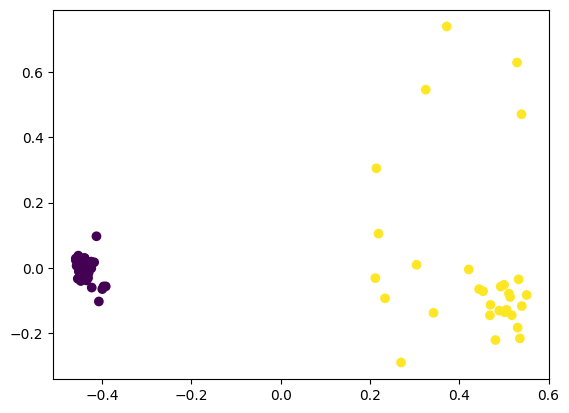

In [26]:
import matplotlib.pyplot as plt

# make a colour map for the points
c = np.array([0 for __ in range(circuits)] + [1 for __ in range(circuits)])

plt.scatter(fit[:, 0], fit[:, 1], c=c)
plt.show()

Looks like the algorithm failed to cluster the data. We can try to get a
separation by increasing the number of shots. Let's increase the number
of shots by 100 and see what happens.


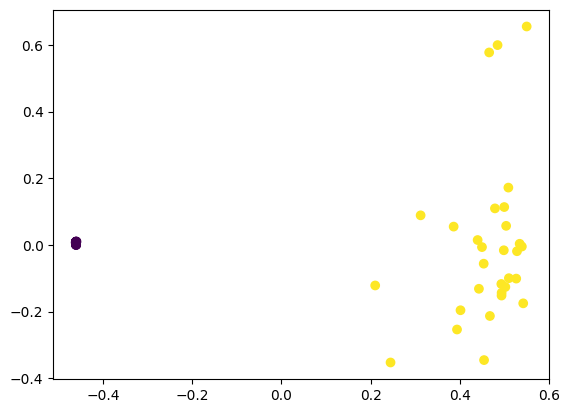

In [27]:
n_shots = 10000  # 100 x more shots

raw_data = []

for ts in [True, False]:
    for __ in range(circuits):
        circuit = generate_circuit(n_shots)
        raw_data.append(circuit(ts=ts))

data = process_data(raw_data)
scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)

fit = kernel_pca.fit(data).transform(data)

plt.scatter(fit[:, 0], fit[:, 1], c=c)
plt.show()

Now we have a separation, however we required a lot of shots from the
quantum circuit. As we increase the number of qubits, the number of
shots we need will scale exponentially (as shown in [\[2\]](#ref2)), and
so conventional strategies cannot learn to separate the data
efficiently.


The quantum-enhanced way
========================

Now let's see what difference having a quantum memory can make. Instead
of using a single unitary to generate measurement data, we will make use
of twice the number of qubits, and apply the unitary twice:


![](../demonstrations/learning_from_experiments/fig3b.png){.align-center
width="70.0%"}


In practice, this could be done by storing the output state from the
first unitary in quantum memory and preparing the same state by using
the unitary again. Let's define a function `enhanced_circuit()` to
implement that. Note that since we now have twice as many qubits, we use
half the number of shots as before so that the total number of uses of
the unitary is unchanged.


In [28]:
n_shots = 50
qubits = 8

dev = qml.device("default.qubit", wires=qubits * 2, shots=n_shots)


@qml.qnode(dev)
def enhanced_circuit(ts=False):
    "implement the enhanced circuit, using a random unitary"

    if ts == True:
        ops = [qml.RY]
    else:
        ops = [qml.RX, qml.RY, qml.RZ]

    weights = np.random.rand(layers, n_shots) * np.pi
    seed = np.random.randint(0, 10000)

    for q in range(qubits):
        qml.Hadamard(wires=q)

    qml.broadcast(
        qml.CNOT, pattern=[[q, qubits + q] for q in range(qubits)], wires=range(qubits * 2)
    )
    RandomLayers(weights, wires=range(0, qubits), ratio_imprim=0.0001, rotations=ops, seed=seed)
    RandomLayers(weights, wires=range(qubits, 2 * qubits), ratio_imprim=0.0001, rotations=ops, seed=seed)
    qml.broadcast(
        qml.CNOT, pattern=[[q, qubits + q] for q in range(qubits)], wires=range(qubits * 2)
    )

    for q in range(qubits):
        qml.Hadamard(wires=q)

    return [qml.sample(op=qml.PauliZ(q)) for q in range(2 * qubits)]

Now we generate some raw measurement data, and calculate the mean and
variance of each qubit as before. Our data vectors are now twice as long
since we have twice the number of qubits.


In [29]:
raw_data = []

for ts in [True, False]:
    for __ in range(circuits):
        raw_data.append(enhanced_circuit(ts))

data = process_data(raw_data)

Let's throw that into Kernel PCA again and plot the result.


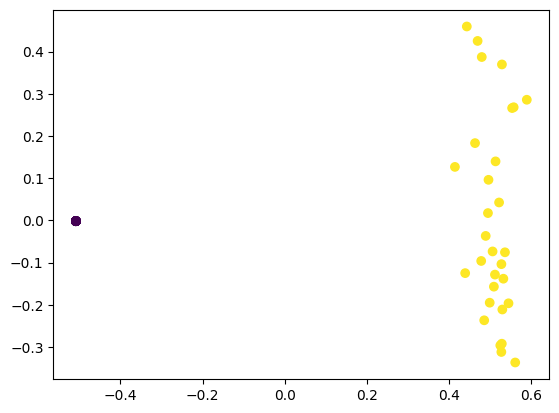

In [30]:
kernel_pca = KernelPCA(
    n_components=None, kernel="rbf", gamma=None, fit_inverse_transform=True, alpha=0.1
)

scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)

fit = kernel_pca.fit(data).transform(data)

c = np.array([0 for __ in range(circuits)] + [1 for __ in range(circuits)])
plt.scatter(fit[:, 0], fit[:, 1], c=c)
plt.show()

Kernel PCA has perfectly separated the two classes! In fact, all the
T-symmetric unitaries have been mapped to the same point. This is
because the circuit is actually equivalent to performing
$U^TU\otimes \mathbb{I}\vert 0 \rangle$, which for T-symmetric unitaries
is just the identity operation.

To see this, note that the Hadamard and CNOT gates before
$U_i\otimes U_i$ map the $\vert0\rangle$ state to the maximally entanged
state
$\vert \Phi^+\rangle = \frac{1}{\sqrt{2}}(\vert 00...0\rangle+ \vert11...1\rangle$,
and the gates after $U_i\otimes U_i$ are just the inverse
transformation. The probability that all measurement outcomes give the
result $+1$ is therefore.

$$p(11\cdots 1) = \langle \Phi^+ \vert U_i \otimes U_i \vert\Phi^+ \rangle.$$

A well known fact about the maximally entanged state is that
$U\otimes \mathbb{I}\vert\Phi^+\rangle= \mathbb{I}\otimes U^T\vert\Phi^+\rangle$.
The probabilty is therefore

$$p(11\cdots 1) = \langle \Phi^+ \vert U_i^T U_i \otimes \mathbb{I} \vert\Phi^+ \rangle.$$

For T-symmetric unitaries $U_i^T=U_i^\dagger$, so this probability is
equal to one: the $11\cdots 1$ outcome is always obtained.

If we look at the raw measurement data for the T-symmetric unitaries:


In [31]:
np.array(raw_data[0])[:, 0:5]  # outcomes of first 5 shots of the first T-symmetric circuit

tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]], requires_grad=True)

We see that indeed this is the only measurement outcome.

To make things a bit more interesting, let's add some noise to the
circuit. We will define a function `noise_layer(epsilon)` that adds some
random single qubit rotations, where the maximum rotation angle is
`epsilon`.


In [32]:
def noise_layer(epsilon):
    "apply a random rotation to each qubit"
    for q in range(2 * qubits):
        angles = (2 * np.random.rand(3) - 1) * epsilon
        qml.Rot(angles[0], angles[1], angles[2], wires=q)

We redefine our `enhanced_circuit()` function with a noise layer applied
after the unitaries


In [33]:
@qml.qnode(dev)
def enhanced_circuit(ts=False):
    "implement the enhanced circuit, using a random unitary with a noise layer"

    if ts == True:
        ops = [qml.RY]
    else:
        ops = [qml.RX, qml.RY, qml.RZ]

    weights = np.random.rand(layers, n_shots) * np.pi
    seed = np.random.randint(0, 10000)

    for q in range(qubits):
        qml.Hadamard(wires=q)

    qml.broadcast(
        qml.CNOT, pattern=[[q, qubits + q] for q in range(qubits)], wires=range(qubits * 2)
    )
    RandomLayers(weights, wires=range(0, qubits), ratio_imprim=0.0001, rotations=ops, seed=seed)
    RandomLayers(weights, wires=range(qubits, 2 * qubits), ratio_imprim=0.0001, rotations=ops, seed=seed)
    noise_layer(np.pi / 4)  # added noise layer
    qml.broadcast(
        qml.CNOT, pattern=[[qubits + q, q] for q in range(qubits)], wires=range(qubits * 2)
    )

    for q in range(qubits):
        qml.Hadamard(wires=qubits + q)

    return [qml.sample(op=qml.PauliZ(q)) for q in range(2 * qubits)]

Now we generate the data and feed it to kernel PCA again.


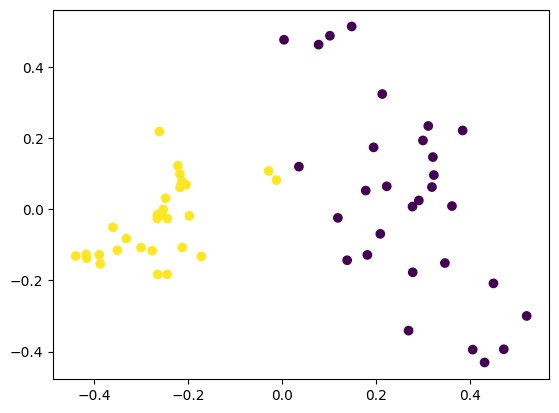

In [34]:
raw_data = []

for ts in [True, False]:
    for __ in range(circuits):
        raw_data.append(enhanced_circuit(ts))

data = process_data(raw_data)

kernel_pca = KernelPCA(
    n_components=None, kernel="rbf", gamma=None, fit_inverse_transform=True, alpha=0.1
)
scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)
fit = kernel_pca.fit(data).transform(data)

c = np.array([0 for __ in range(circuits)] + [1 for __ in range(circuits)])
plt.scatter(fit[:, 0], fit[:, 1], c=c)
plt.show()

Nice! Even in the presence of noise we still have a clean separation of
the two classes. This shows that using entanglement can make a big
difference to learning.


In [35]:
seconds = time.time()
print("Time in seconds since end of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since end of run: 1700504057.9524357
Mon Nov 20 18:14:17 2023


References
==========

\[1\] *Quantum advantage in learning from experiments*, Hsin-Yuan Huang
et. al., [arxiv:2112.00778](https://arxiv.org/pdf/2112.00778.pdf) (2021)

\[2\] *Exponential separations between learning with and without quantum
memory*, Sitan Chen, Jordan Cotler, Hsin-Yuan Huang, Jerry Li,
[arxiv:2111.05881](https://arxiv.org/abs/2111.05881) (2021)

About the author
================
